# Spread Prediction using Machine Learning methods

Pairs that I found are derived by several pair-trading logics. And those have made some movements in certain stable ranges. So I assumed that moving stably means somewhat predictable whether next day spread will go up or down. Even though predicting a spread's next value or direction might not be valuable by itself, it can be used as trading timing information. In other words, if a spread makes a signal of short-selling we may want to know which timing is better to trade (now or tomorrow or the other day). I tested several machine learning models (DecisionTreeClassifier, BoostingModels, RandomForest etc) with hyper-parameter tuning, bench-marking simple N-days moving average reversion method.  


* Two version of modeling : Y=Spread(future) | Y=Direction of Spread(future)
* X1 : Past Spread
* X2 : Spread - Exponential Moving Average (short term direction)
* X3 : Standard Deviation of Spread (Volatility)
* X4 : Sum of two stocks' volumes (Volume Liquidity)
* X5 : Momentum (Spread - Spread-10daysAgo) (might not be proper cuz highly correlated with X2)
* X6 : KOSPI (checking market factor)


In [132]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
import matplotlib.font_manager as fm
import pyautogui
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython import display
import pydotplus
from sklearn import pipeline, metrics
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [21]:
import sys
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='z')

---

### Feature Engineering

In [30]:
def SpreadValues(code1, code2, eta, start, end):
    pr = ldr.GetPricelv2(start, end, [code1,code2])
    log_pr = np.log(pr)
    spread = pd.DataFrame((log_pr[code1] - log_pr[code2] * eta),columns=['spread'])
    return spread

In [31]:
def SpreadDirection(code1, code2, eta, start, end, ndays=5):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-ndays]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_dir = spread - spread.ewm(ndays, min_periods=1).mean()
    spread_dir = spread_dir[spread_dir.index>=start]
    spread_dir.columns=['DIR']
    return spread_dir

In [32]:
def SpreadSTD(code1, code2, eta, start, end, ndays=5):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-ndays]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_STD = spread.rolling(ndays, min_periods=1).std()
    spread_STD = spread_STD[spread_STD.index>=start]
    spread_STD.columns=['STD']
    return spread_STD

In [33]:
def SpreadVolume(code1, code2, start, end):
    vol_lv1 = ldr.GetPricelv1(start,end,[code1,code2])
    dates = ldr.GetTradingDays(start,end)
    vol_df = pd.DataFrame(index=dates, columns=['SUMVOL'])
    for dt in dates :
        vol_df.loc[dt,'SUMVOL'] = vol_lv1[(vol_lv1.DATE==dt)&(vol_lv1.CODE.isin([code1,code2]))].volume.sum()
    return vol_df

In [34]:
def SpreadMomentum(code1, code2, eta, start, end, diff_day=10):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-diff_day]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_diff = spread.diff(diff_day)
    spread_diff = spread_diff[spread_diff.index>=start]
    spread_diff.columns=['Momentum']
    return spread_diff

In [37]:
def SpreadSign(start, end, code1, code2, eta, raw=False):
    tdays = ldr.GetTradingDays()
    end_idx = tdays.index(end)
    next_day = tdays[end_idx+1]
    spd = SpreadValues(code1, code2, eta, start, next_day)
    spd_raw = spd.diff(1).shift(-1).iloc[:-1,:]
    diff_raw = spd_raw.copy()
    f = lambda x : 1 if x>=0 else 0
    spd_raw['spread'] = spd_raw['spread'].map(f)
    if raw :
        return spd_raw, diff_raw
    else :
        return spd_raw

---

### Features Visualization

In [35]:
def Visual_v2(code1, code2, eta, start, end):
    font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=15)
    color=iter(cm.rainbow(np.linspace(0,1,3)))
    
    spread = SpreadValues(code1,code2,eta,start,end)
    spread_dir = SpreadDirection(code1,code2,eta,start,end)
    spread_STD = SpreadSTD(code1,code2,eta,start,end)
    spread_VOL = SpreadVolume(code1,code2,start,end)
    spread_MOM = SpreadMomentum(code1,code2,eta,start,end)
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(6, 1, 1)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax1.plot(spread.reset_index().index, spread.values,color='black', label='Spread')
    ax1.legend(loc='upper left')

    ax2 = fig.add_subplot(6, 1, 2)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax2.plot(spread_dir.reset_index().index, spread_dir, color='blue' ,label='SpreadDirection')
    ax2.legend(loc='upper left')
    
    ax3 = fig.add_subplot(6, 1, 3)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax3.plot(spread_STD.reset_index().index, spread_STD, color='red',label='SpreadSTD')
    ax3.legend(loc='upper left')
    
    ax4 = fig.add_subplot(6, 1, 4)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax4.plot(spread_VOL.reset_index().index, spread_VOL, color='magenta',label='SpreadVOL')
    ax4.legend(loc='upper left')
    
    ax5 = fig.add_subplot(6, 1, 5)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax5.plot(spread_MOM.reset_index().index, spread_MOM, color='purple', label='SpreadMomentum')
    ax5.legend(loc='upper left')
    
    plt.show()
    return True

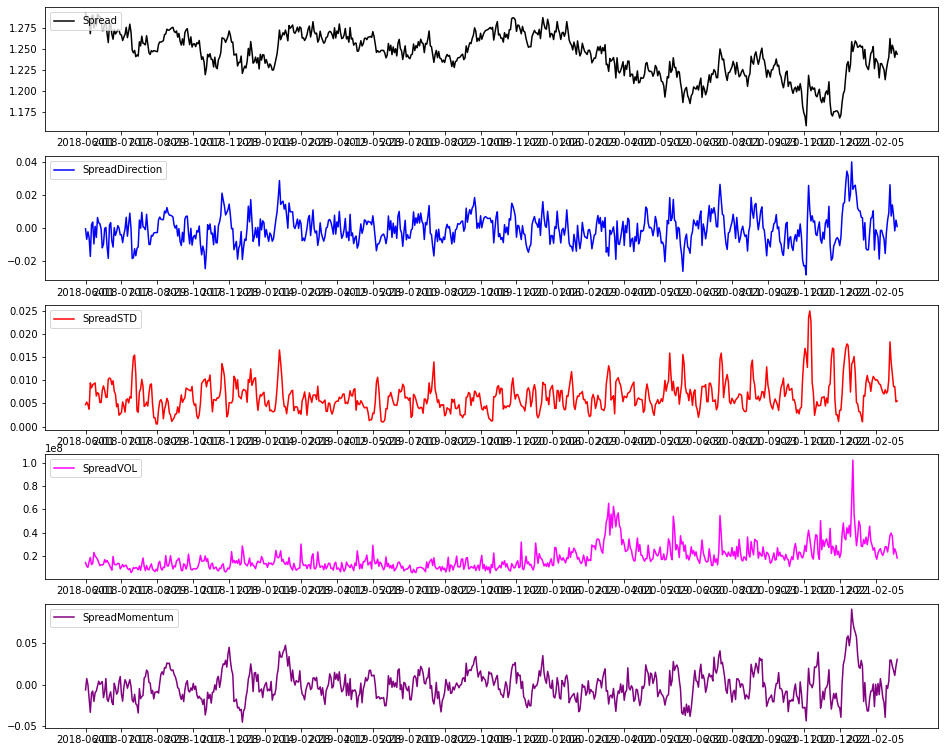

True

In [36]:
Visual_v2('005930','005935',0.9,'2018-06-01','2021-03-08')

---

### Data Arrangement

In [38]:
%%time
code1 = '005930'
code2 = '005935'
eta = 0.9
start = '2018-06-01'
end = '2021-03-05'
spread = SpreadValues(code1,code2,eta,start,end)
spread_dir = SpreadDirection(code1,code2,eta,start,end)
spread_STD = SpreadSTD(code1,code2,eta,start,end)
spread_VOL = SpreadVolume(code1,code2,start,end)
spread_MOM = SpreadMomentum(code1,code2,eta,start,end)
pr = ldr.GetPricelv2(start,end,[code1])
ksp = ldr.GetKOSPI(start,end)

Xs = pd.concat([spread,spread_dir,spread_STD,spread_VOL,ksp],axis=1)
Y = SpreadSign(start, end, code1, code2, eta)

Wall time: 4.01 s


In [39]:
Xs.shape, Y.shape

((678, 5), (678, 1))

In [41]:
X_train = Xs[Xs.index<='2020-11-31']
X_test = Xs[Xs.index>'2020-11-31']
Y_train = Y[Y.index<='2020-11-31']
Y_test = Y[Y.index>'2020-11-31']

In [42]:
dtc = DecisionTreeClassifier()

In [201]:
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [202]:
dtc.score(X_test,Y_test)

0.5079365079365079

In [205]:
export_graphviz(dtc, out_file='tree.dot')

In [206]:
dt_dot_data = tree.export_graphviz(dtc,out_file=None,feature_names=list(Xs.columns),
                    class_names=['Plus','Minus'],filled=True,max_depth=3,
                    rounded=True,special_characters=True)

In [207]:
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

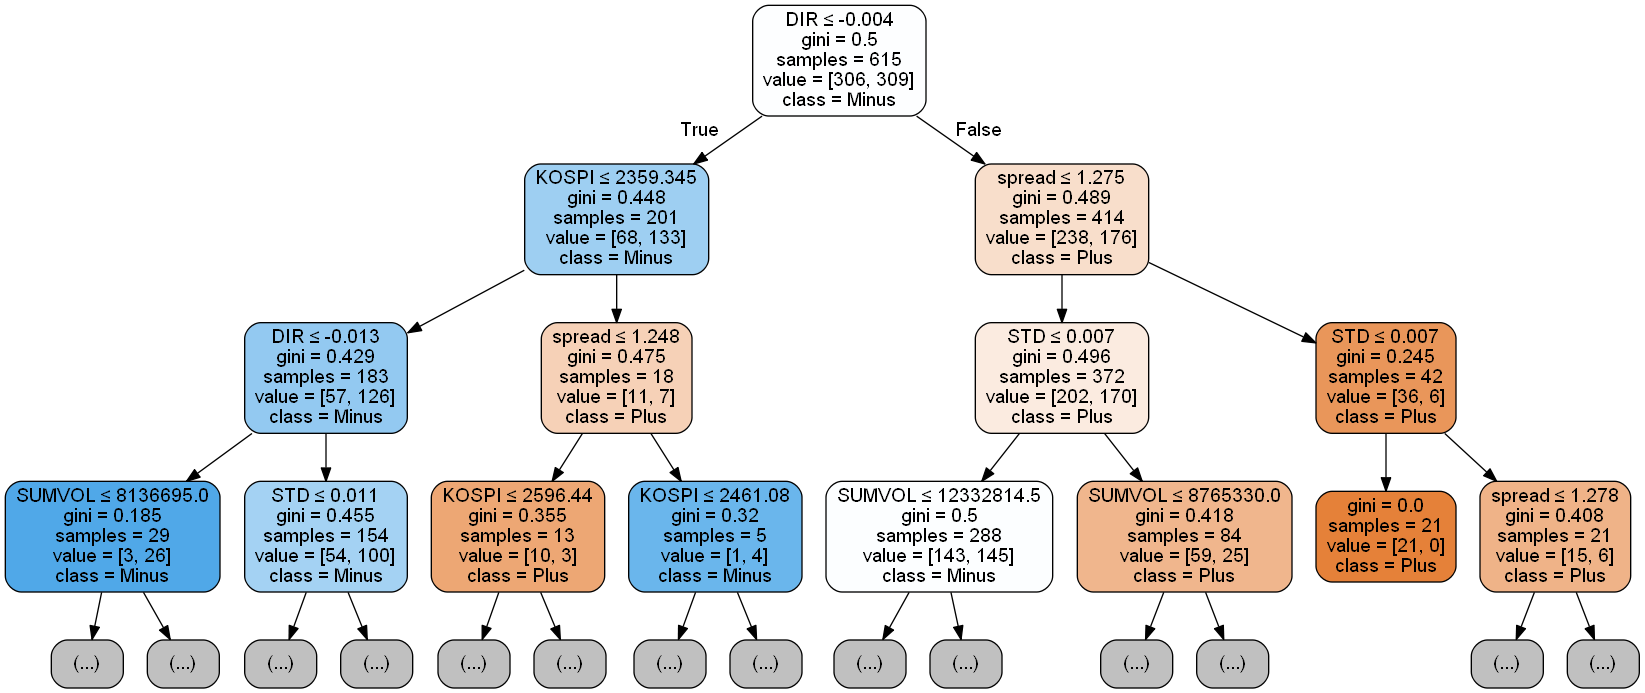

In [208]:
Image(dt_graph.create_png())

<AxesSubplot:>

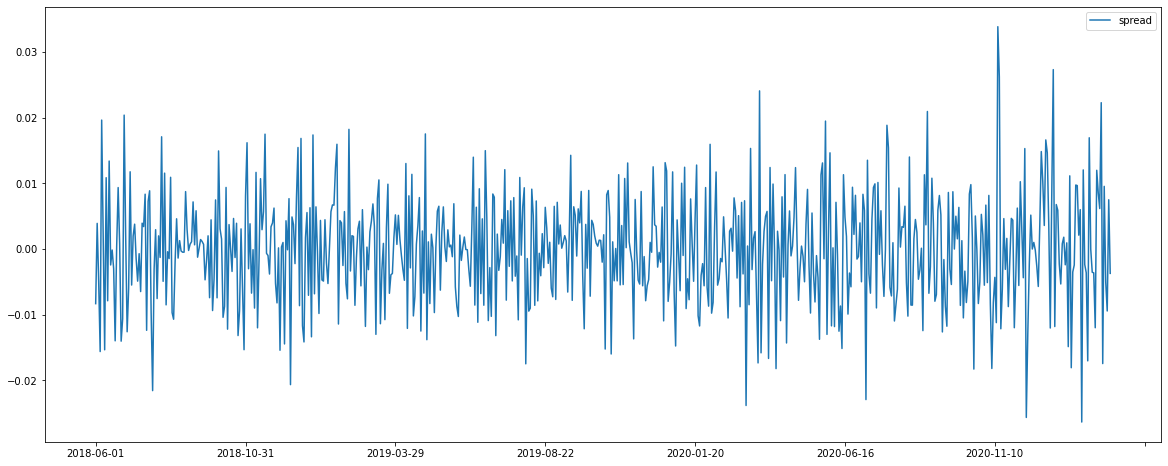

In [241]:
spd_diff.plot(figsize=(20,8))

* It seems like no prediction power at all..
* 5days Moving Average Reversion could be more predictable...

---

### Hyper Parameter Tuning

In [44]:
def gini(solution, submission):
    df = zip(solution, submission, range(len(solution)))
    df = sorted(df, key=lambda x: (x[1],-x[2]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

In [45]:
my_scorer = metrics.make_scorer(normalized_gini, greater_is_better = True)

In [46]:
DTC_base = DecisionTreeClassifier()

In [59]:
print("Base Score : {}".format(np.mean(cross_val_score(DTC_base, X_train, Y_train['spread'], scoring = my_scorer, cv=10))))

Base Score : 0.1690322580645162


In [79]:
DTC_params_opt = {
    'max_depth' : np.linspace(3, 32, 10,dtype=int, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 5, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
}

In [80]:
%%time
DTC_grid_opt = GridSearchCV(DTC_base, param_grid=DTC_params_opt, scoring=my_scorer, cv=5, verbose=1)
DTC_grid_opt.fit(X_train, Y_train['spread'])

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 6.56 s


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    6.4s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 19, 22, 25, 28, 32]),
                         'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'min_samples_split': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring=make_scorer(normalized_gini), verbose=1)

In [81]:
print("Best Score : {}".format(DTC_grid_opt.best_score_))
print("Best Params : {}".format(DTC_grid_opt.best_params_))

Best Score : 0.2694870438921205
Best Params : {'max_depth': 3, 'min_samples_leaf': 0.4, 'min_samples_split': 0.1}


In [82]:
best_DTC_model = DTC_grid_opt.best_estimator_

In [83]:
best_DTC_model

DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.4, min_samples_split=0.1)

In [84]:
best_DTC_model.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.4, min_samples_split=0.1)

In [85]:
best_DTC_model.score(X_test,Y_test)

0.4603174603174603

In [88]:
gbm = GradientBoostingClassifier(learning_rate=0.1,
                                 n_estimators=100
)
print("Base Score : {}".format(np.mean(cross_val_score(gbm, X_train, Y_train['spread'], scoring = my_scorer, cv=5))))

Base Score : 0.19894235854045472


In [90]:
gbm_params_1 = {
    'min_samples_split' : [int(n*p*0.01) for p in range(5,10,2) for n in [len(X_train)]],
    'min_samples_leaf' : [30, 50],
    'max_depth' : [5,7,9],
    'max_features' : ['sqrt'],
    'subsample' : [0.5, 0.8],
}

In [92]:
gbm_grid_1 = GridSearchCV(gbm, param_grid=gbm_params_1, scoring=my_scorer, cv=5, verbose=1)
gbm_grid_1.fit(X_train, Y_train['spread'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   16.9s finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [5, 7, 9], 'max_features': ['sqrt'],
                         'min_samples_leaf': [30, 50],
                         'min_samples_split': [30, 43, 55],
                         'subsample': [0.5, 0.8]},
             scoring=make_scorer(normalized_gini), verbose=1)

In [93]:
print("Best Score : {}".format(gbm_grid_1.best_score_))
print("Best Params : {}".format(gbm_grid_1.best_params_))
best_gbm_model = gbm_grid_1.best_estimator_

Best Score : 0.2677948175568482
Best Params : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 30, 'subsample': 0.5}


In [94]:
gbm_params_2 = {
    'learning_rate' : [0.01, 0.05, 0.07, 0.1, 0.2],
    'n_estimators' : [n for n in range(80,200,20)]
}
gbm_grid_2 = GridSearchCV(best_gbm_model, param_grid=gbm_params_2, scoring=my_scorer, cv=5, verbose=1)
gbm_grid_2.fit(X_train, Y_train['spread'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.5s finished


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=30,
                                                  subsample=0.5),
             param_grid={'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2],
                         'n_estimators': [80, 100, 120, 140, 160, 180]},
             scoring=make_scorer(normalized_gini), verbose=1)

In [95]:
print("Best Score : {}".format(gbm_grid_2.best_score_))
print("Best Params : {}".format(gbm_grid_2.best_params_))
best_gbm_model = gbm_grid_2.best_estimator_

Best Score : 0.28101533580116345
Best Params : {'learning_rate': 0.01, 'n_estimators': 100}


In [96]:
best_gbm_model.score(X_test,Y_test)

0.5079365079365079

In [97]:
ada_params = {
    'learning_rate' : [0.03, 0.07, 0.1],
    'n_estimators' : [n for n in range(80,130,20)]
}
ada_grid = GridSearchCV(AdaBoostClassifier(), param_grid=ada_params, scoring=my_scorer, cv=5, verbose=1)
ada_grid.fit(X_train, Y_train['spread'])

print("Best Score : {}".format(ada_grid.best_score_))
print("Best Params : {}".format(ada_grid.best_params_))
best_ada_model = ada_grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score : 0.24505552617662613
Best Params : {'learning_rate': 0.03, 'n_estimators': 80}


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    9.4s finished


In [98]:
best_ada_model.score(X_test,Y_test)

0.4603174603174603

* Scores near 0.5 are frustrating.
* No need to further works, so I quickly tested ('034200','066570') pair and quited.

In [101]:
%%time
code1 = '034220'
code2 = '066570'
eta = 0.7
start = '2018-06-01'
end = '2021-03-05'
spread = SpreadValues(code1,code2,eta,start,end)
spread_dir = SpreadDirection(code1,code2,eta,start,end)
spread_STD = SpreadSTD(code1,code2,eta,start,end)
spread_VOL = SpreadVolume(code1,code2,start,end)
spread_MOM = SpreadMomentum(code1,code2,eta,start,end)
pr = ldr.GetPricelv2(start,end,[code1])
ksp = ldr.GetKOSPI(start,end)

Xs = pd.concat([spread,spread_dir,spread_STD,spread_VOL,ksp],axis=1)
Y = SpreadSign(start, end, code1, code2, eta)

Wall time: 5.09 s


In [109]:
X_train = Xs[Xs.index<='2020-11-31']
X_test = Xs[Xs.index>'2020-11-31']
Y_train = Y[Y.index<='2020-11-31']
Y_test = Y[Y.index>'2020-11-31']

In [110]:
DTC_base = DecisionTreeClassifier()
print("Base Score : {}".format(np.mean(cross_val_score(DTC_base, X_train, Y_train['spread'], scoring = my_scorer, cv=10))))

Base Score : 0.04374720107478728


In [111]:
DTC_params_opt = {
    'max_depth' : np.linspace(3, 32, 10,dtype=int, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 5, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
}
DTC_grid_opt = GridSearchCV(DTC_base, param_grid=DTC_params_opt, scoring=my_scorer, cv=5, verbose=1)
DTC_grid_opt.fit(X_train, Y_train['spread'])

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    7.3s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 19, 22, 25, 28, 32]),
                         'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'min_samples_split': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring=make_scorer(normalized_gini), verbose=1)

In [112]:
print("Best Score : {}".format(DTC_grid_opt.best_score_))
print("Best Params : {}".format(DTC_grid_opt.best_params_))

Best Score : 0.16960762165843835
Best Params : {'max_depth': 3, 'min_samples_leaf': 0.30000000000000004, 'min_samples_split': 0.1}


In [113]:
best_DTC_model = DTC_grid_opt.best_estimator_

In [114]:
best_DTC_model.score(X_test,Y_test)

0.47619047619047616

---

### Conclusion
* I think spread prediction is absurd as much as predicting a stock price is.
* Spread means a relative position of two stock prices so even if there actually exists a intrinsic relationship its discrepancy could be white noise.
* As I derived pair-tradable pairs, white noise testing can be the clue of that.